# Commmunity Analysis

### Importing libraries

In [1]:
import networkx as nx
import numpy as np
from networkx.algorithms.community.quality import modularity
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import networkx as nx
import re


First, we will inspect the network

### Loading the graph

In [2]:
# Load graph and make undirected
G = nx.read_graphml("data/world_graph_attributes.graphml")
G = G.to_undirected()

In [3]:
print(len(G.nodes()))
for node, data in G.nodes(data=True):
    print(node, data)

192
Afghanistan {'sentiment_score': 2.6, 'continent': 'Asia', 'gdp': 502.115, 'official_language': 'Pashto'}
China {'sentiment_score': 5.4, 'continent': 'Asia', 'gdp': 14244.678, 'official_language': 'Standard Chinese'}
Egypt {'sentiment_score': 4.1, 'continent': 'Africa', 'gdp': 3020.031, 'official_language': 'Modern Standard Arabic'}
France {'sentiment_score': 5.5, 'continent': 'Europe', 'gdp': 40493.929, 'official_language': 'French'}
Germany {'sentiment_score': 5.0, 'continent': 'Europe', 'gdp': 46258.878, 'official_language': 'German'}
India {'sentiment_score': 6.1, 'continent': 'Asia', 'gdp': 1910.836, 'official_language': 'Hindi'}
Iran {'sentiment_score': 5.0, 'continent': 'Asia', 'gdp': 5371.177, 'official_language': 'Persian'}
Italy {'sentiment_score': 6.0, 'continent': 'Europe', 'gdp': 33189.566, 'official_language': 'Italian'}
Pakistan {'sentiment_score': 5.0, 'continent': 'Asia', 'gdp': 1405.581, 'official_language': 'Urdu'}
Qatar {'sentiment_score': 6.4, 'continent': 'Asia

### Forming Louvain Communities

In [4]:
# Building the Louvain partition using NetworkX's built-in function (define a seed for reproducibility)
louvain_communities = nx.community.louvain_communities(G, seed = 10)
print(f"Total communities formed using Louvain method: {len(louvain_communities)}\n")


for i, community in enumerate(louvain_communities):
    print(f"Louvain Community {i+1} (n = {len(community)}): {list(community)[:5]}")
print("---")

Total communities formed using Louvain method: 5

Louvain Community 1 (n = 23): ['Pakistan', 'Algeria', 'Egypt', 'Iraq', 'Libya']
Louvain Community 2 (n = 34): ['Peru', 'Venezuela', 'Argentina', 'Bolivia', 'Ecuador']
Louvain Community 3 (n = 51): ['Zimbabwe', 'Mali', 'Somalia', 'Mauritius', 'Ghana']
Louvain Community 4 (n = 46): ['Ireland', 'Romania', 'Kazakhstan', 'Finland', 'Monaco']
Louvain Community 5 (n = 38): ['Bangladesh', 'Brunei', 'Tonga', 'Micronesia', 'Malaysia']
---


# Communities by attribute partitions

In [5]:
def classify_nodes_by_attribute(G, attribute, k=3):
    """
    Returns a dictionary mapping class_label -> list_of_nodes.
    The attribute has a higher value in the the higher levels.
    """

    # Collect values only from nodes that have the attribute (can be erased once the network is perfect)
    #values = []
    #nodes_with_attr = []
#
    #for n, data in G.nodes(data=True):
    #    if attribute not in data:
    #        print(f"Node '{n}' is missing attribute '{attribute}' — skipping.")
    #        continue
#
    #    # Extract attribute values
    #    values.append(data[attribute])
    #    nodes_with_attr.append(n)

    # Store the values
    #vals = np.array(values)
    vals = np.array([G.nodes[n][attribute] for n in G.nodes])

    #Use log to colapse the scale 
    vals = np.log(vals + 1) 

    # Compute partition boundaries
    bins = np.linspace(vals.min(), vals.max(), k + 1)

    # Create labels: Level_1, Level_2, ..., Level_k
    labels = [f"Level_{i+1}" for i in range(k)]

    # Prepare output dictionary
    classes = {label: [] for label in labels}

    # Assign nodes to classes
    for node, data in G.nodes(data=True):
        value = data.get(attribute)

        # Skip if missing
        if value is None:
            print(f"Node {node} has no attribute '{attribute}'")
            continue

        # Determine the partition index
        idx = np.digitize(value, bins) - 1 
        # clamp to valid range 
        idx = min(max(idx, 0), k-1)        

        classes[labels[idx]].append(node)

    return classes


In [6]:
def classify_nodes_by_attribute(G, attribute, k=3):
    """
    Classify countries into k levels based on the log of the attribute.
    """
    # extract attribute values
    vals = []
    for n in G.nodes:
        if attribute in G.nodes[n]:
            vals.append(G.nodes[n][attribute])

    vals = np.array(vals)

    # log-transform
    log_vals = np.log(vals + 1)

    # compute bins on log scale
    bins = np.linspace(log_vals.min(), log_vals.max(), k + 1)

    labels = [f"Level_{i+1}" for i in range(k)]
    classes = {label: [] for label in labels}

    # Assign nodes to classes
    for node, data in G.nodes(data=True):
        value = data.get(attribute)

        if value is None:
            print(f"Node {node} has no attribute '{attribute}'")
            continue

        # log-transform the node value too
        log_value = np.log(value + 1)

        idx = np.digitize(log_value, bins) - 1
        idx = min(max(idx, 0), k - 1)

        classes[labels[idx]].append(node)

    return classes


### Forming communities by language

Now we will try to form communities based on language. Does not work now with the new network (does not have language). 

In [7]:
# ...existing code...
from collections import defaultdict
language_communities = defaultdict(list)

for node, data in G.nodes(data=True):
    language = data.get("official_language")
    if language is None:
        # optional: collect missing nodes for inspection
        # missing_language_nodes.append(node)
        continue
    language_communities[language].append(node)

# convert to list of sets (what modularity expects)
language_partitions = [set(nodes) for nodes in language_communities.values()]


### Forming communities by continent

In [8]:
CONTINENTS = {
    "Africa": [
        "Algeria","Angola","Benin","Botswana","Burkina_Faso","Burundi",
        "Cameroon","Cape_Verde","Central_African_Republic","Chad","Comoros",
        "Congo","Democratic_Republic_of_the_Congo","Djibouti","Egypt",
        "Equatorial_Guinea","Eritrea","Eswatini","Ethiopia","Gabon",
        "Gambia","Ghana","Guinea","Guinea-Bissau","Ivory_Coast","Kenya",
        "Lesotho","Liberia","Libya","Madagascar","Malawi","Mali",
        "Mauritania","Mauritius","Morocco","Mozambique","Namibia","Niger",
        "Nigeria","Republic_of_the_Congo","Rwanda","São_Tomé_and_Príncipe",
        "Senegal","Seychelles","Sierra_Leone","Somalia","South_Africa",
        "South_Sudan","Sudan","Tanzania","The_Gambia","Togo","Tunisia",
        "Uganda","Zambia","Zimbabwe"
    ],

    "Asia": [
        "Afghanistan","Armenia","Azerbaijan","Bahrain","Bangladesh",
        "Bhutan","Brunei","Cambodia","China","Cyprus","Georgia","India",
        "Indonesia","Iran","Iraq","Israel","Japan","Jordan","Kazakhstan",
        "Kuwait","Kyrgyzstan","Laos","Lebanon","Malaysia","Maldives",
        "Mongolia","Myanmar","Nepal","North_Korea","Oman","Pakistan",
        "Philippines","Qatar","Saudi_Arabia","Singapore","South_Korea",
        "Sri_Lanka","Syria","Tajikistan","Thailand","Timor-Leste",
        "Turkey","Turkmenistan","United_Arab_Emirates","Uzbekistan",
        "Vietnam","Yemen"
    ],

    "Europe": [
        "Albania","Andorra","Austria","Belarus","Belgium","Bosnia_and_Herzegovina",
        "Bulgaria","Croatia","Czech_Republic","Denmark","Estonia","Finland",
        "France","Germany","Greece","Hungary","Iceland","Ireland","Italy",
        "Kazakhstan","Kosovo","Latvia","Liechtenstein","Lithuania","Luxembourg",
        "Malta","Moldova","Monaco","Montenegro","Netherlands","North_Macedonia",
        "Norway","Poland","Portugal","Romania","Russia","San_Marino","Serbia",
        "Slovakia","Slovenia","Spain","Sweden","Switzerland","Ukraine",
        "United_Kingdom"
    ],

    "North_America": [
        "Antigua_and_Barbuda","Bahamas","Barbados","Belize","Canada","Costa_Rica",
        "Cuba","Dominica","Dominican_Republic","El_Salvador","Grenada","Guatemala",
        "Haiti","Honduras","Jamaica","Mexico","Nicaragua","Panama",
        "Saint_Kitts_and_Nevis","Saint_Lucia","Saint_Vincent_and_the_Grenadines",
        "The_Bahamas","Trinidad_and_Tobago","United_States"
    ],

    "South_America": [
        "Argentina","Bolivia","Brazil","Chile","Colombia","Ecuador","Guyana",
        "Paraguay","Peru","Suriname","Uruguay","Venezuela"
    ],

    "Oceania": [
        "Australia","Fiji","Kiribati","Marshall_Islands","Micronesia","Nauru",
        "New_Zealand","Palau","Papua_New_Guinea","Samoa","Solomon_Islands",
        "Tonga","Tuvalu","Vanuatu"
    ]
}
# create continent partitions similar to GDP partitions

continent_communities = defaultdict(list)

for node, data in G.nodes(data=True):
    continent = data.get("continent")
    if continent is None:
        # optional: collect missing nodes for inspection
        # missing_language_nodes.append(node)
        continue
    continent_communities[continent].append(node)

# convert to list of sets (what modularity expects)
continent_partitions = [set(nodes) for nodes in continent_communities.values()]

### Forming community by GDP

In [9]:
gdp_partitions = classify_nodes_by_attribute(G,'gdp', k=5)

In [10]:
print(len(gdp_partitions["Level_1"]), "elements")
print(len(gdp_partitions["Level_1"]))

26 elements
26


In [11]:
print(len(gdp_partitions["Level_2"]), "elements")
print(len(gdp_partitions["Level_2"]))

46 elements
46


In [12]:
print(len(gdp_partitions["Level_3"]))

60


### Forming communities by History Sentiment Score

In [13]:
sentiment_partitions = classify_nodes_by_attribute(G, "sentiment_score", k=5)

In [14]:
print(len(sentiment_partitions["Level_1"]), "elements")
sentiment_partitions["Level_1"][:5] # TO SHOW


3 elements


['Afghanistan', 'Haiti', 'South_Sudan']

In [15]:
print(len(sentiment_partitions["Level_2"]), "elements")
sentiment_partitions["Level_2"][:5] # TO SHOW

17 elements


['Mali', 'Yemen', 'Democratic_Republic_of_the_Congo', 'Guinea', 'Zimbabwe']

In [16]:
print(len(sentiment_partitions["Level_2"]), "elements")
sentiment_partitions["Level_3"][:5] # TO SHOW

17 elements


['Egypt', 'Russia', 'Uzbekistan', 'Bosnia_and_Herzegovina', 'Serbia']

# Analysing the communities

### Calculating the Modularity of the different partitions

Modularity (GDP partitions): 0.0532
Total communities formed using GDP partitions: 5

Modularity (Sentiment partitions): 0.0092
Total communities formed using Sentiment partitions: 5

Modularity (Louvain communities): 0.3660
Total communities formed using Louvain method: 5

Modularity (Continent partitions): 0.3032
Total communities formed using Continent partitions: 6

Modularity (Language partitions): 0.1121
Total communities formed using Language partitions: 81



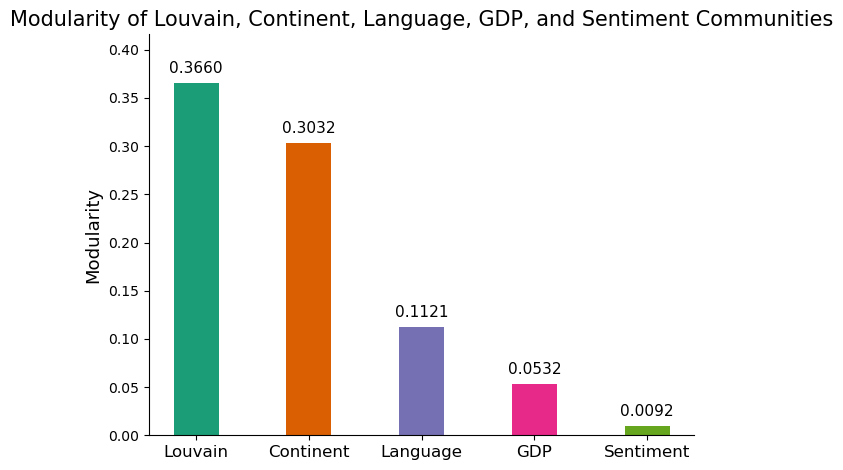

In [17]:
# Calculate modularity for GDP partitions
gdp_modularity = modularity(G, gdp_partitions.values())
print(f"Modularity (GDP partitions): {gdp_modularity:.4f}")
# PRINT NUMBER OF COMMUNITIES IN GDP PARTITIONS
print(f"Total communities formed using GDP partitions: {len(gdp_partitions)}\n")

# Calculate modularity for sentiment partitions
sentiment_modularity = modularity(G, sentiment_partitions.values())
print(f"Modularity (Sentiment partitions): {sentiment_modularity:.4f}")
# PRINT NUMBER OF COOMUNITIES IN SENTIMENT PARTITIONS
print(f"Total communities formed using Sentiment partitions: {len(sentiment_partitions)}\n")

# Calculate modularity for Louvain communities
louvain_modularity = modularity(G, louvain_communities)
print(f"Modularity (Louvain communities): {louvain_modularity:.4f}")
# PRINT NUMBER OF COMMUNITIES IN LOUVAIN METHOD
print(f"Total communities formed using Louvain method: {len(louvain_communities)}\n")

# Continent partitions modularity
continent_modularity = modularity(G, continent_partitions)
print(f"Modularity (Continent partitions): {continent_modularity:.4f}")
# PRINT NUMBER OF COMMUNITIES IN CONTINENT PARTITIONS
print(f"Total communities formed using Continent partitions: {len(continent_partitions)}\n")

# Language partitions modularity
language_modularity = modularity(G, language_partitions)
print(f"Modularity (Language partitions): {language_modularity:.4f}")
# PRINT NUMBER OF COMMUNITIES IN LANGUAGE PARTITIONS
print(f"Total communities formed using Language partitions: {len(language_partitions)}\n")

# Plot the modularity values for comparison with improved colors
labels = ['Louvain', 'Continent', 'Language', 'GDP', 'Sentiment']
modularity_values = [louvain_modularity, continent_modularity, language_modularity, gdp_modularity, sentiment_modularity]
x = np.arange(len(labels))
width = 0.4

# Use more distinct and colorblind-friendly colors
bar_colors = ['#1b9e77', '#d95f02', '#7570b3', '#e7298a', '#66a61e']

fig, ax = plt.subplots()
bars = ax.bar(x, modularity_values, width, color=bar_colors, linewidth=1.2)
ax.set_ylabel('Modularity', fontsize=13)
ax.set_title('Modularity of Louvain, Continent, Language, GDP, and Sentiment Communities', fontsize=15)
ax.set_xticks(x)
ax.set_xticklabels(labels, fontsize=12)
ax.set_ylim(0, max(modularity_values) + 0.05)

for bar in bars:
    height = bar.get_height()
    ax.annotate(f'{height:.4f}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 5),
                textcoords="offset points",
                ha='center', va='bottom', fontsize=11)

sns.despine()
plt.tight_layout()
plt.show()


### Visualizing the commmunity graphs

Visualizing the communities for all partitions...



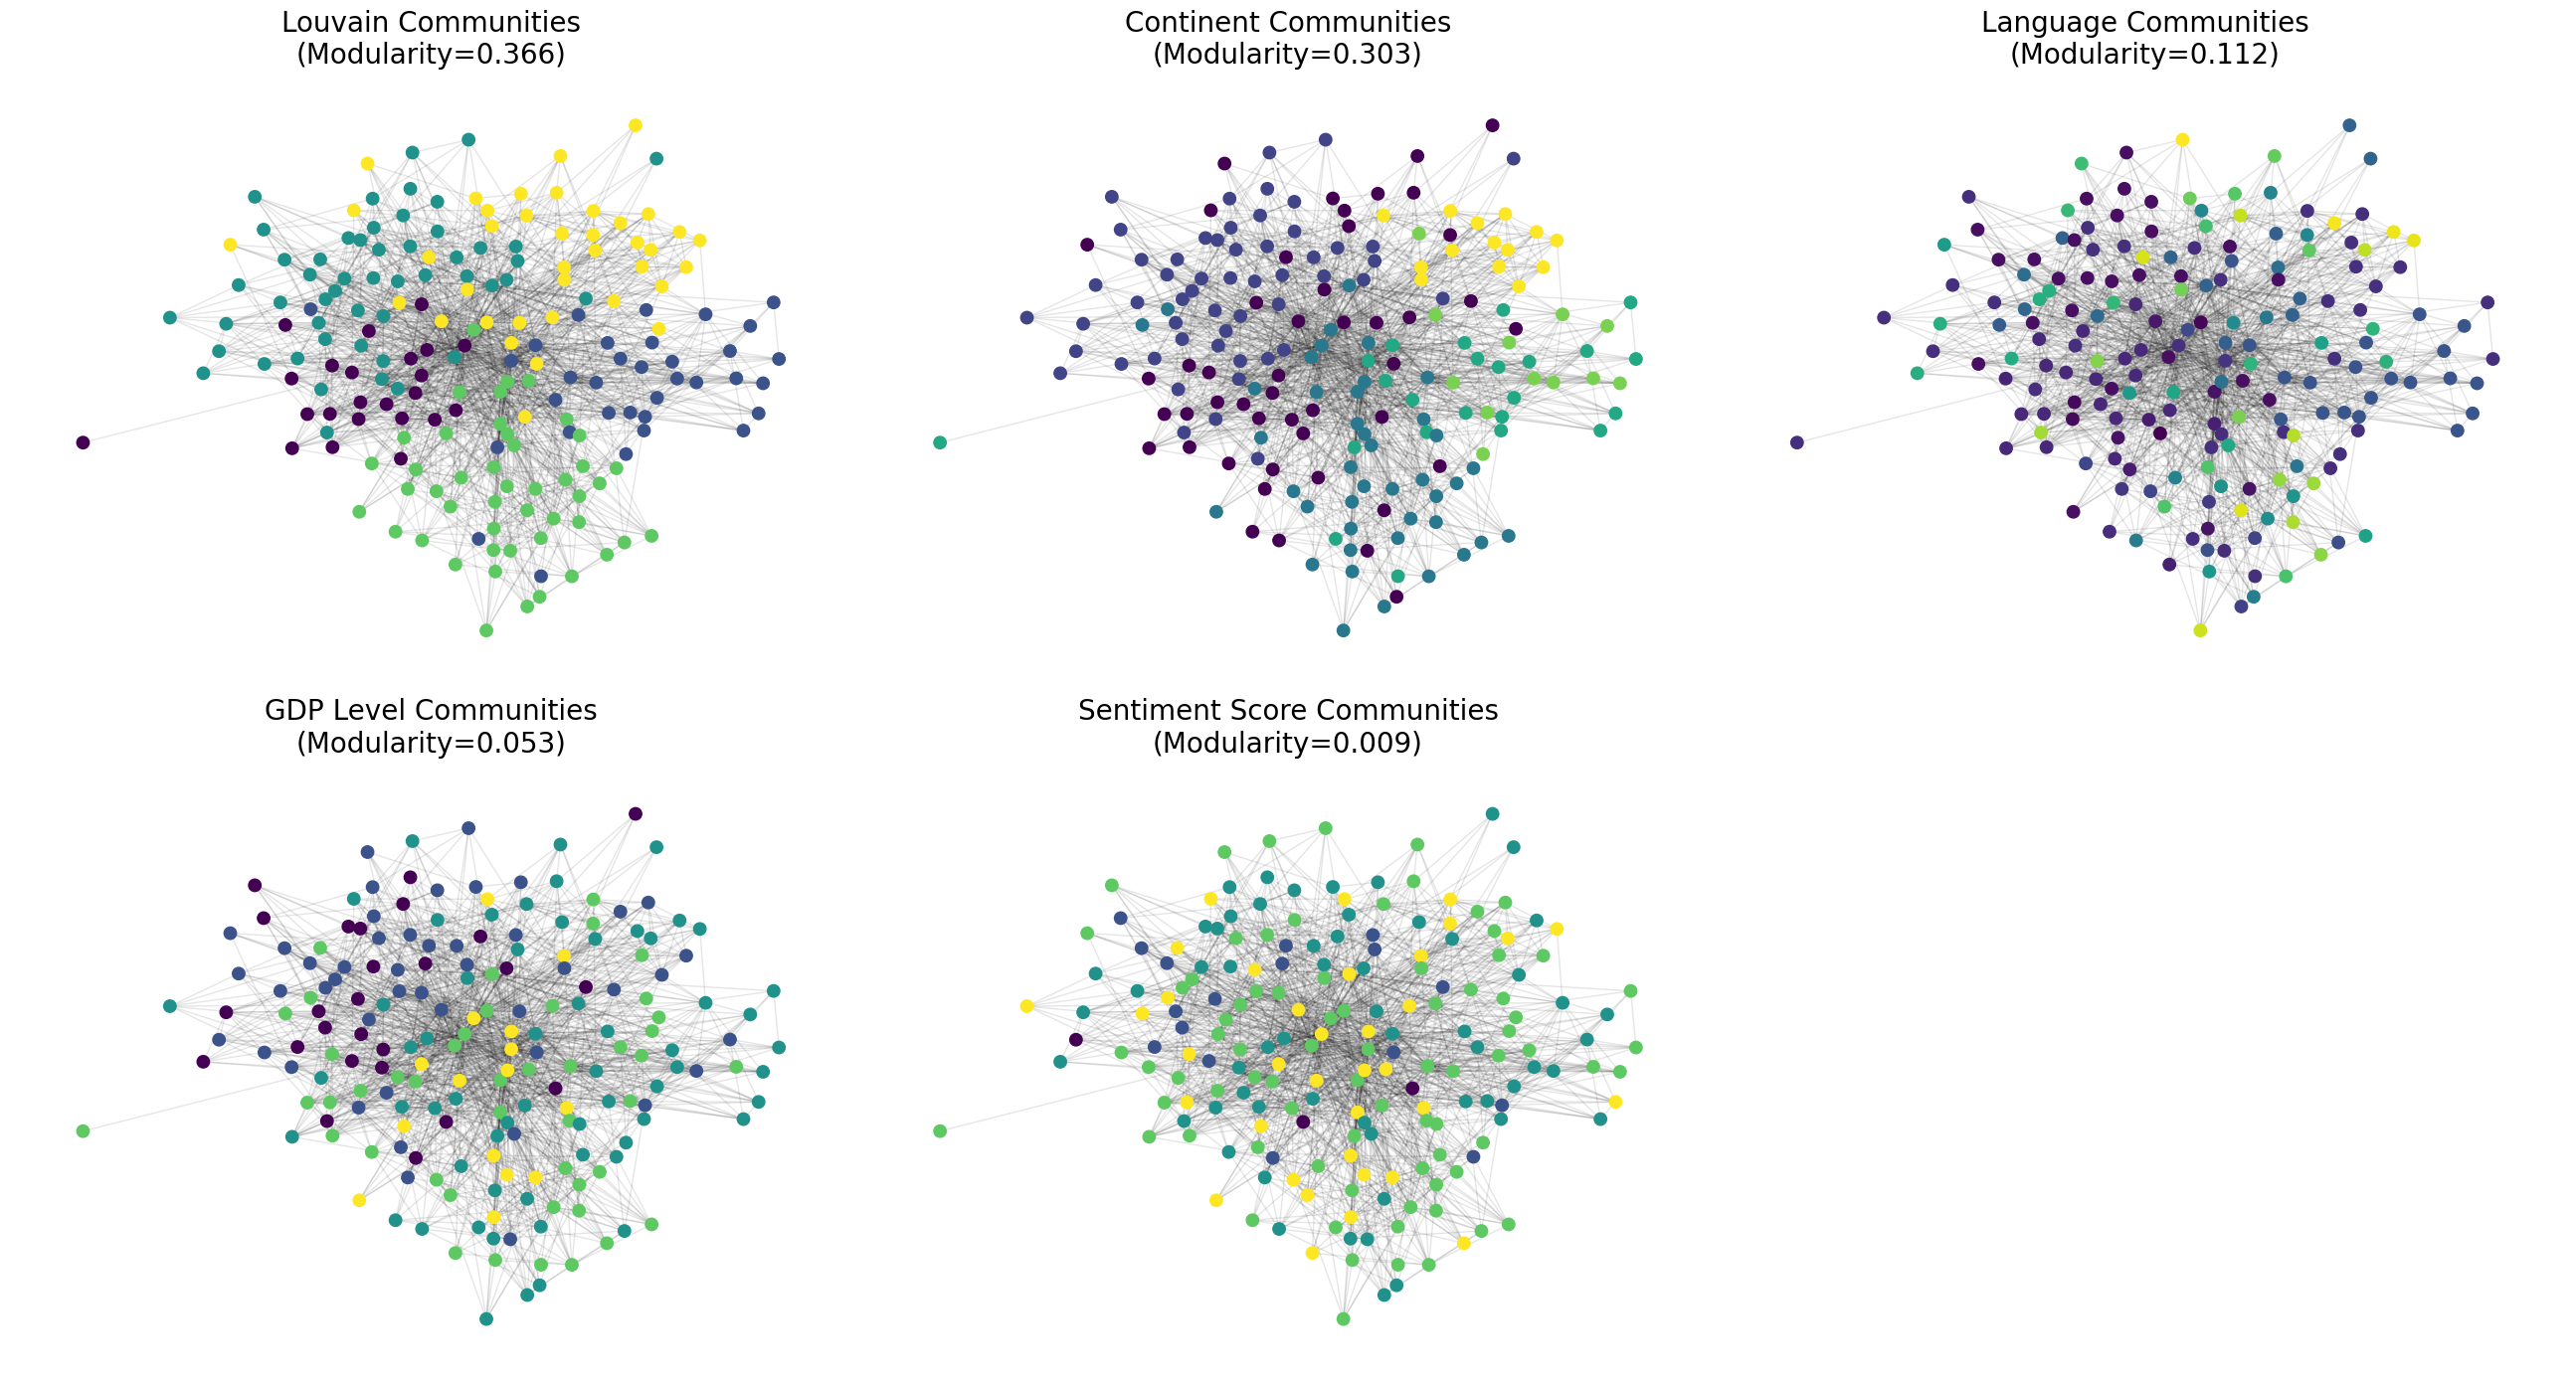

In [18]:
print("Visualizing the communities for all partitions...\n")

fig, axes = plt.subplots(2, 3, figsize=(26, 14))
axes = axes.flatten()
pos = nx.spring_layout(G, seed=42)

def partition_to_colors(G, partitions):
    """Map each node to an integer color index based on its partition."""
    groups = list(partitions.values())
    return [
        next(i for i, group in enumerate(groups) if node in group)
        for node in G.nodes()
    ]

# Map partitions to colors
colors_map = [
    ("Louvain Communities",          louvain_colors := partition_to_colors(G, {i:c for i, c in enumerate(louvain_communities)}), louvain_modularity),
    ("Continent Communities",        continent_colors := partition_to_colors(G, continent_communities), continent_modularity),
    ("Language Communities",         language_colors := partition_to_colors(G, language_communities), language_modularity),
    ("GDP Level Communities",        gdp_colors := partition_to_colors(G, gdp_partitions), gdp_modularity),
    ("Sentiment Score Communities",  sentiment_colors := partition_to_colors(G, sentiment_partitions), sentiment_modularity),
]

for ax, (title, color_list, modularity) in zip(axes, colors_map):
    ax.set_title(f"{title}\n(Modularity={modularity:.3f})", fontsize=20)
    nx.draw_networkx_nodes(G, pos, node_size=80, node_color=color_list,
                           cmap=plt.cm.viridis, ax=ax)
    nx.draw_networkx_edges(G, pos, alpha=0.1, ax=ax)
    ax.axis("off")

# Hide unused 6th subplot (if only 5 plots)
axes[-1].axis("off")

plt.tight_layout()
plt.show()




### Visualization of the Matrix _D_

Generating confusion matrices for all community factors...



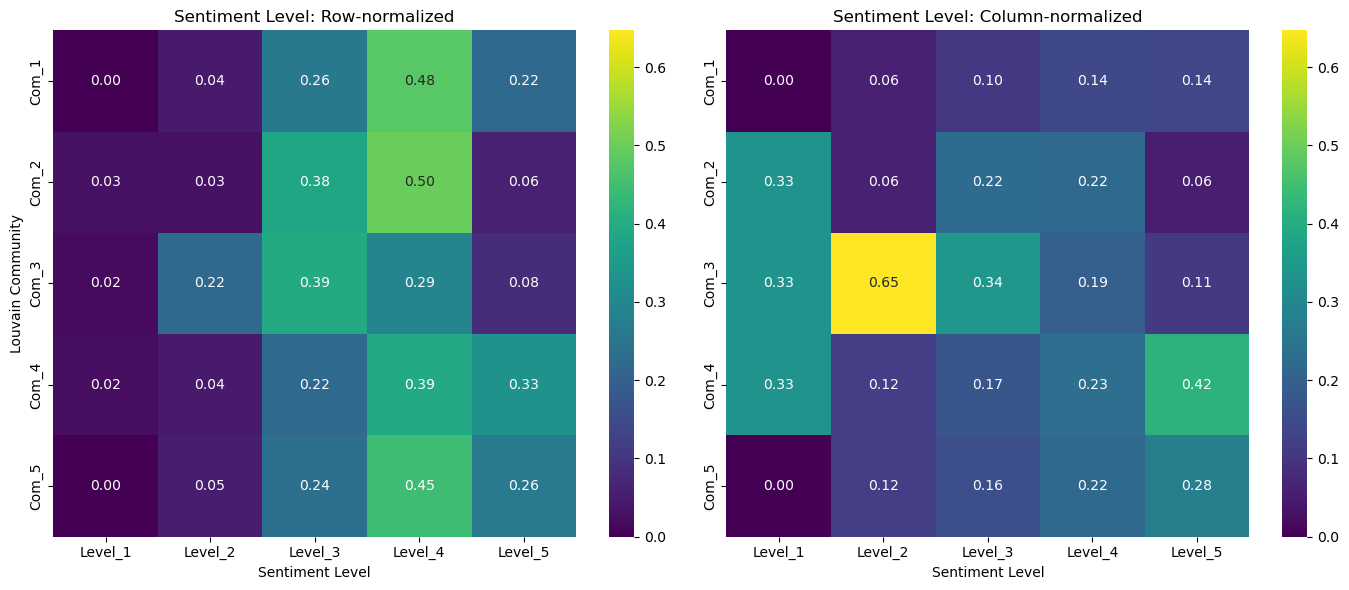

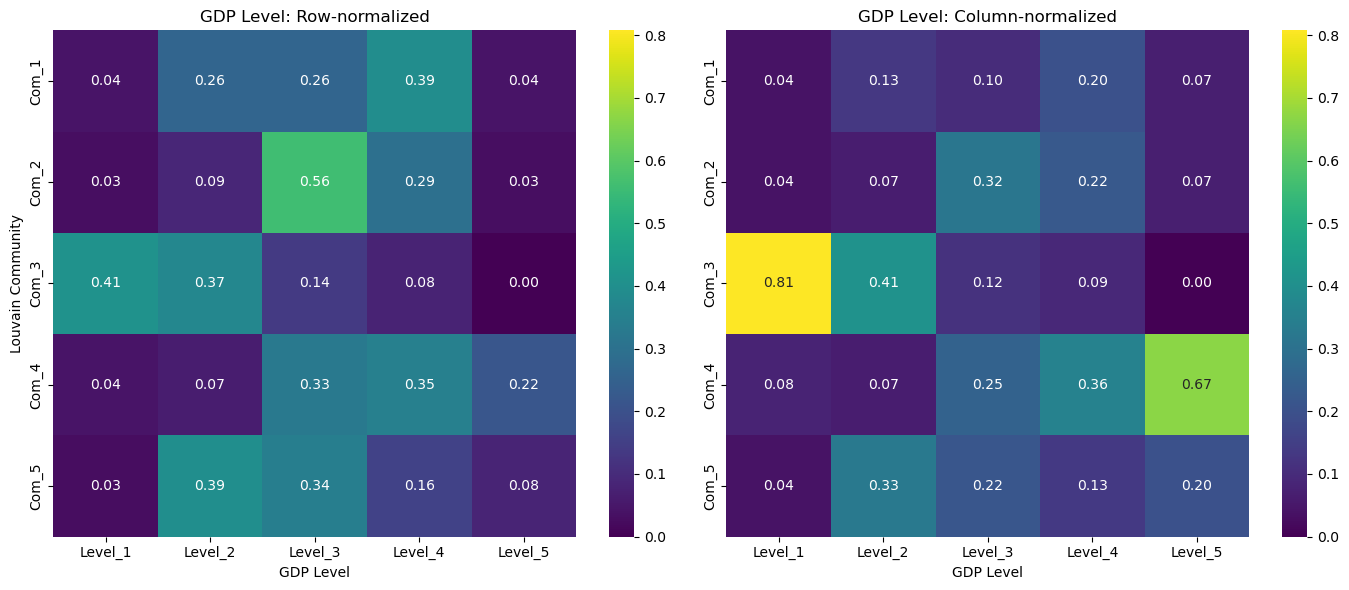

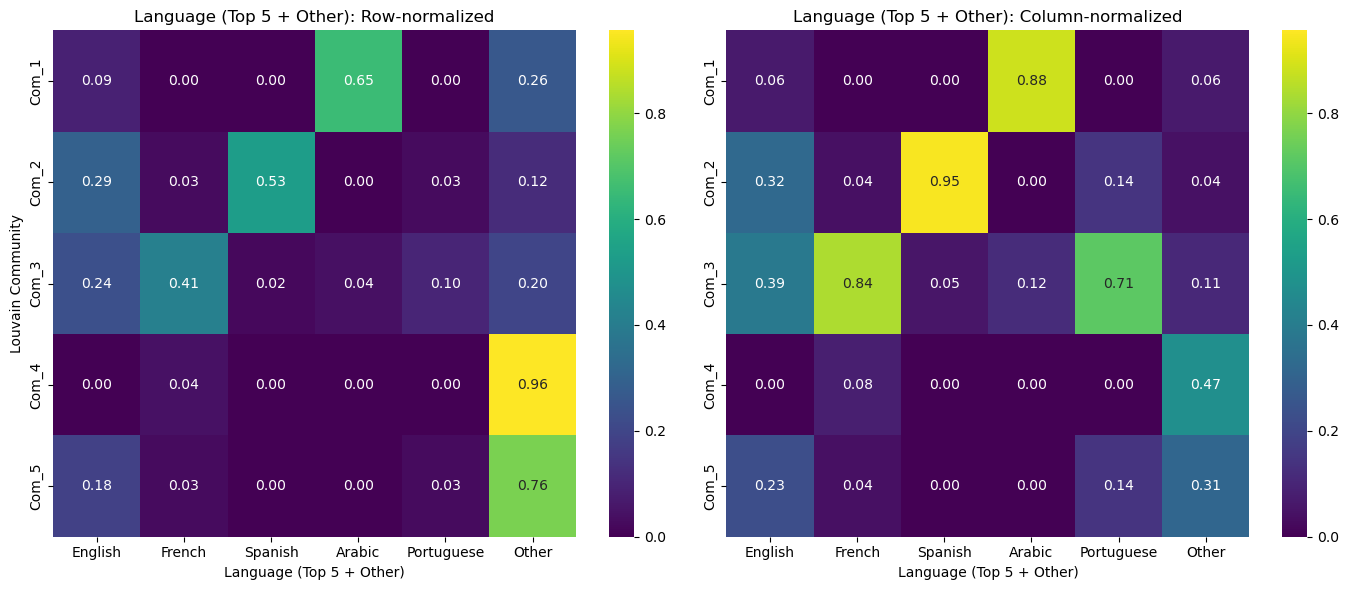

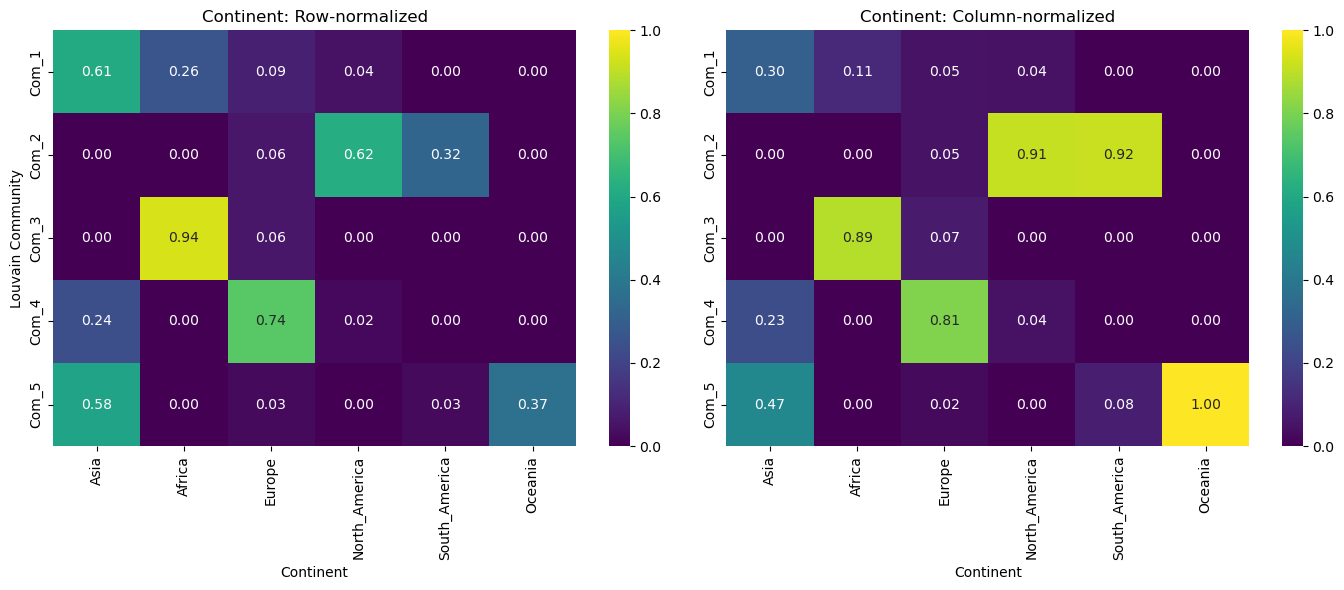

In [24]:
print("Generating confusion matrices for all community factors...\n")

def make_confusion_matrix(row_groups, col_groups):
    """
    row_groups: list of node-lists (e.g., Louvain communities)
    col_groups: dict mapping label → node-list
    """
    rows = len(row_groups)
    cols = len(col_groups)
    matrix = np.zeros((rows, cols), dtype=int)

    col_keys = list(col_groups.keys())

    for i, row_group in enumerate(row_groups):
        row_set = set(row_group)
        for j, key in enumerate(col_keys):
            col_set = set(col_groups[key])
            matrix[i, j] = len(row_set & col_set)

    return matrix, col_keys


def reduce_to_top_k(partition_dict, k=5):
    """
    Keeps top-k largest groups, merges remaining groups into 'Other'.
    partition_dict: {label → list_of_nodes}
    """
    # Sort by size
    sorted_items = sorted(partition_dict.items(), key=lambda x: len(x[1]), reverse=True)

    # Top-k
    top_k = dict(sorted_items[:k])

    # All remaining grouped together
    other_nodes = []
    for key, nodes in sorted_items[k:]:
        other_nodes.extend(nodes)

    if other_nodes:
        top_k["Other"] = other_nodes

    return top_k


def plot_normalized_matrices(matrix, row_labels, col_labels, factor_name):
    """
    Plots row-normalized and column-normalized heatmaps for a confusion matrix.
    """

    row_norm = matrix / matrix.sum(axis=1, keepdims=True)
    col_norm = matrix / matrix.sum(axis=0, keepdims=True)

    vmax = max(row_norm.max(), col_norm.max())
    vmin = min(row_norm.min(), col_norm.min())

    plt.figure(figsize=(14, 6))

    # ---- Row-normalized ----
    plt.subplot(1, 2, 1)
    sns.heatmap(
        row_norm, annot=True, fmt='.2f', cmap='viridis',
        xticklabels=col_labels, yticklabels=row_labels,
        vmin=vmin, vmax=vmax
    )
    plt.title(f"{factor_name}: Row-normalized")
    plt.xlabel(factor_name)
    plt.ylabel("Louvain Community")

    # ---- Column-normalized ----
    plt.subplot(1, 2, 2)
    sns.heatmap(
        col_norm, annot=True, fmt='.2f', cmap='viridis',
        xticklabels=col_labels, yticklabels=row_labels,
        vmin=vmin, vmax=vmax
    )
    plt.title(f"{factor_name}: Column-normalized")
    plt.xlabel(factor_name)
    plt.ylabel("")

    plt.tight_layout()
    plt.show()


# ---------------------------
# PREPROCESS: Language → Top 5 + Other
# ---------------------------

language_top5 = reduce_to_top_k(language_communities, k=5)

# ---------------------------
# FACTOR CONFIGURATION
# ---------------------------

factors = [
    ("Sentiment Level", sentiment_partitions),
    ("GDP Level",       gdp_partitions),
    ("Language (Top 5 + Other)", language_top5),
    ("Continent",       continent_communities),
]

# ---------------------------
# PLOT ALL MATRICES
# ---------------------------

for factor_name, partitions in factors:

    matrix, col_labels = make_confusion_matrix(
        louvain_communities,
        partitions
    )

    # Raw confusion matrix
    #plt.figure(figsize=(8, 6))
    #sns.heatmap(
        #matrix, annot=True, fmt="d", cmap="viridis",
        #xticklabels=col_labels,
        #yticklabels=[f"Com_{i+1}" for i in range(len(louvain_communities))]
    #)
    #plt.title(f"Confusion Matrix: Louvain Communities vs {factor_name}")
    #plt.xlabel(factor_name)
    #plt.ylabel("Louvain Community")
    #plt.tight_layout()
    #plt.show()

    # Normalized versions
    row_labels = [f"Com_{i+1}" for i in range(len(louvain_communities))]

    plot_normalized_matrices(
        matrix,
        row_labels=row_labels,
        col_labels=col_labels,
        factor_name=factor_name
    )


Results of TF-IDF are not making much sense right now. I believe considering GDP per capita will result in a better behaviour. 

# TF-IDF 

In [ ]:
import os
import math
import random
import string
import pickle as pkl
from io import StringIO
from pathlib import Path
from collections import Counter, defaultdict
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
from wordcloud import WordCloud
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer


This function will be used to eliminate the countries names from the countries wikipages. We will also try to eliminate nationalities. 

In [ ]:
countries = list(G.nodes())

In [ ]:
NATIONALITIES = [
    "Afghan", "Albanian", "Algerian", "American", "Andorran", "Angolan",
    "Antiguan", "Argentine", "Armenian", "Australian", "Austrian",
    "Azerbaijani", "Bahamian", "Bahraini", "Bangladeshi", "Barbadian",
    "Belarusian", "Belgian", "Belizean", "Beninese", "Bhutanese",
    "Bolivian", "Bosnian", "Botswanan", "Brazilian", "British", "Bruneian",
    "Bulgarian", "Burkinabe", "Burmese", "Burundian", "Cambodian",
    "Cameroonian", "Canadian", "Cape Verdean", "Central African",
    "Chadian", "Chilean", "Chinese", "Colombian", "Comorian",
    "Congolese", "Costa Rican", "Croatian", "Cuban", "Cypriot",
    "Czech", "Danish", "Djiboutian", "Dominican", "Dutch",
    "East Timorese", "Ecuadorian", "Ecuadorean",
    "Egyptian", "Emirati", "English", "Equatoguinean",
    "Eritrean", "Estonian", "Ethiopian", "Fijian", "Filipino",
    "Philippine", 
    "Finnish", "French", "Gabonese", "Gambian", "Georgian", "German",
    "Ghanaian", "Greek", "Grenadian", "Guatemalan", "Guinean",
    "Guyanese", "Haitian", "Honduran", "Hungarian", "Icelandic",
    "Indian", "Indonesian", "Iranian", "Iraqi", "Irish",
    "Israeli", "Italian", "Jamaican", "Japanese", "Jordanian",
    "Kazakh", "Kenyan", "Kiribati", "Kittitian", "Korean", "Kosovar",
    "Kuwaiti", "Kyrgyz", "Lao", "Latvian", "Lebanese", "Liberian",
    "Libyan", "Liechtensteiner", "Lithuanian", "Luxembourger", "Luxembourgish",
    "Macedonian", 
    "Malagasy", "Malawian", "Malaysian", "Maldivian", "Malian",
    "Maltese", "Marshallese", "Mauritanian", "Mauritian", "Mexican",
    "Micronesian", "Moldovan", "Monacan", "Mongolian", "Montenegrin",
    "Moroccan", "Mozambican", "Namibian", "Nauruan", "Nepalese",
    "New Zealander", "Nicaraguan", "Nigerian", "Nigerien", "Niuean",
    "Norwegian", "Omani", "Pakistani", "Palauan", "Palestinian", "Panamanian",
    "Papua New Guinean", "Paraguayan", "Peruvian", "Polish",
    "Portuguese", "Qatari", "Romanian", "Russian", "Rwandan",
    "Salvadoran", "Sammarinese", "Samoan", "Saudi", "Scottish",
    "Senegalese", "Serbian", "Seychellois", "Sierra Leonean",
    "Singaporean", "Slovak", "Slovenian", "Slovene", 
    "Somali", "South African", "South Sudanese", "Spanish",
    "Sri Lankan", "Sudanese", "Surinamese", "Swazi", "Swedish",
    "Swiss", "Syrian", "Taiwanese", "Tajik", "Tanzanian", "Thai",
    "Togolese", "Tongan", "Trinidadian", "Tunisian", "Turkish",
    "Turkmen", "Tuvaluan", "Ugandan", "Ukrainian", "Uruguayan",
    "Uzbek", "Vanuatuan", "Venezuelan", "Vietnamese", "Welsh",
    "Yemeni", "Zambian", "Zimbabwean",
    "Czechoslovakian", "Transjordanian", "Burman", "Burmese",
]

EXTRA_COUNTRIES = [
    "Burma",
    "Macedonia",
    "Czechoslovakia",
    "Transjordan",
    "Nubia",
    "Anatolia",
    "Bosnia",
    "Bahamas",
    "Trinidad",
    "Tobago",
    "Herzegovina",
    "Congo",
    "Saint",
    "Vincent",
    "Grenadines",
    "Korea",
    "Palestine",
    "Macedonia", 
    "Timor"
]

EXTRA_TERMS = [ "url"]

country_list = countries + EXTRA_COUNTRIES + EXTRA_TERMS



In [ ]:

def clean_countries_and_nationalities(
    source_folder,
    dest_folder,
    country_list,
    nationalities
):
    source = Path(source_folder)
    dest = Path(dest_folder)
    dest.mkdir(parents=True, exist_ok=True)

    # Prepare country names 
    cleaned_countries = [
        c.replace("_", " ").title() for c in country_list
    ]

    country_terms = []

    for c in cleaned_countries:
        country_terms.append(c)          
        country_terms.append(c.lower())  
        country_terms.append(c + "s")        
        country_terms.append(c.lower() + "s")  

    # Prepare nationalities 
    nationality_terms = []

    for nat in nationalities:
        singular_title = nat
        singular_lower = nat.lower()
        plural_title = nat + "s"
        plural_title = nat + "es"
        plural_lower = nat.lower() + "s"

        nationality_terms.extend([
            singular_title,
            singular_lower,
            plural_title,
            plural_lower,
        ])


    # Build final regex
    all_terms = country_terms + nationality_terms

    # Escape and join terms
    pattern = re.compile(
        r"\b(" + "|".join(map(re.escape, all_terms)) + r")\b",
        flags=re.IGNORECASE
    )

    # Process files
    for file in source.glob("*.txt"):
        text = file.read_text(encoding="utf-8")
        cleaned = pattern.sub("", text)
        (dest / file.name).write_text(cleaned, encoding="utf-8")


In [ ]:
clean_countries_and_nationalities(
    source_folder="countries_pages",
    dest_folder="countries_cleaned_plus_nationalities",
    country_list=country_list,
    nationalities=NATIONALITIES,
)

Now we will start with the TF-IDF functions. 

In [ ]:
# initialize the list of common English stopwords and a lemmatizer
stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()


def clean_tokenize(text, rare_threshold=5):
    """
    Clean, tokenize, and lemmatize a text string. Produces unigram and bigram tokens.
    - Lowercase
    - Remove punctuation and numbers
    - Remove stopwords
    - Lemmatize words
    - Filter out rare words considering all the texts (freq < rare_threshold)

    Parameters:
    text: str
        Text being clean 
    rare_threshold: int
        Minimum number of times a word needs to appear in a text to be considered

    Returns
    tokens : list of str
        List of cleaned, lemmatized tokens that occur at least
        'rare_threshold' times in the all the texts.
    """

    # lowercase
    text = text.lower()

    # remove punctuation and numbers
    text = re.sub(r"[^a-z\s]", "", text)

    # tokenize (split on whitespace)
    tokens = text.split()

    # lemmatize
    tokens = [lemmatizer.lemmatize(t) for t in tokens]

    # remove stopwords
    tokens = [t for t in tokens if t not in stop_words]

    # remove very short tokens
    tokens = [t for t in tokens if len(t) > 2]

    # build bigrams
    bigrams = [tokens[i] + "_" + tokens[i+1] for i in range(len(tokens)-1)]

    # combine unigrams + bigrams
    all_tokens = tokens + bigrams

    # filter rare words based on frequencies in this text
    #freq = Counter(all_tokens)
    #all_tokens = [t for t in all_tokens if freq[t] >= rare_threshold]

    # Remove rare words considering all the texts 
    # This way we don't lose rare words that cab be important in historical context
    if rare_threshold:
        freq = Counter(all_tokens)
        all_tokens = [t for t in all_tokens if freq[t] >= rare_threshold]

    return all_tokens


def compute_tf_for_communities(base_path, communities, out_folder, prefix="community"):
    """
    Compute term-frequency lists (TF) for a set of communities.

    Parameters  
    base_path : Path
        Folder with artist text files (.txt)
    communities : dict or list
        - If dict: {community_name: [artists]}
        - If list: [set(artists), set(artists), ...]
    out_folder : Path
        Output folder to store TF files
    prefix : str
        Prefix for naming files (e.g. 'primary', 'random', 'louvain')

    Returns
    genre_texts : dict
        Dictionary mapping each community name to a 'Counter' object containing
        the term frequencies of that community.
    """
    out_folder.mkdir(exist_ok=True)
    genre_texts = defaultdict(list)

    # normalize to dict form for convenience
    if isinstance(communities, list):
        communities = {f"{prefix}_{i+1}": list(c) for i, c in enumerate(communities)}

    # tokenize 
    for name, countries in communities.items():
        combined_tokens = []
        for artist in countries:
            file_path = base_path / f"{artist.replace(' ', '_').lower()}.txt"
            text = file_path.read_text(encoding="utf-8")
            tokens = clean_tokenize(text)
            combined_tokens.extend(tokens)

        # compute and save TF for this community
        counts = Counter(combined_tokens)
        genre_texts[name] = counts

        # store TF lists
        if prefix== "louvain":
            out_file = out_folder / f"{name}_TF.txt"
        else:
            out_file = out_folder / f"{prefix}_{name}_TF.txt"
            
        with open(out_file, "w", encoding="utf-8") as f:
            for word, count in counts.most_common():
                f.write(f"{word} {count}\n")

    return genre_texts

In [ ]:
def compute_tfidf(group_folder, label_type, top_n=10):
    """
    Compute TF-IDF for each group/community from the files containing the TF lists.

    Parameters
    group_folder : str or Path
        Path to the folder containing the TF lists files for each group or community.
    label_type : str
        Label indicating the type of grouping ("primary", "random", or "louvain"),
        used for formatting the printed output.
    top_n : int, optional
        Number of top words to display for each group based on TF-IDF score.
        Default is 10.

    Returns
    group_tfidf : dict
        Dictionary mapping each group name to a dictionary of {word: TF-IDF value}.
        
    """
    group_folder = Path(group_folder)
    group_tf = {}
    all_words = set()

    # load TF lists 
    for file in group_folder.glob("*_TF.txt"):
        name = file.stem  

        #  remove prefix
        for prefix in ["sentiment_score", "gdp_", "louvain_", "continent_"]:
            if name.lower().startswith(prefix):
                prefix_removed = name[len(prefix):]
                detected_prefix = prefix  
                break

        # remove "_TF"
        prefix_removed = prefix_removed[:-3]

        # clean up spacing and capitalization
        clean_name = prefix_removed.strip().upper()

        # store words and frequencies
        counts = Counter()
        with open(file, "r", encoding="utf-8") as f:
            for line in f:
                    word, freq = line.strip().split()
                    freq = int(freq)
                    counts[word] = freq
                    all_words.add(word)
        group_tf[clean_name] = counts

    # compute DF 
    df = Counter()
    for word in all_words:
        df[word] = sum(1 for tf_counts in group_tf.values() if word in tf_counts)

    # compute IDF 
    N = len(group_tf)
    idf = {word: math.log((N + 1) / (df[word] + 1)) for word in all_words}

    # compute TF-IDF 
    group_tfidf = {}
    for group_name, tf_counts in group_tf.items():
        total_words = sum(tf_counts.values())
        tfidf = {word: (count / total_words) * idf[word] for word, count in tf_counts.items()}
        group_tfidf[group_name] = tfidf

    # print the results
    for group_name, tfidf_dict in group_tfidf.items():
        if "louvain" in label_type.lower():
            print(f"\n=== Top {top_n} TF-IDF words for Louvain community {group_name.replace('_', ' ')} ===")
        elif "continent" in label_type.lower():
            print(f"\n=== Top {top_n} TF-IDF words for continent {group_name.replace('_', ' ')} ===")
        elif 'gdp' in label_type.lower():
            print(f"\n=== Top {top_n} TF-IDF words for the {detected_prefix.replace('_', ' ').upper()}attribute: {group_name.replace('_', ' ').title()} ===")
        else: 
            print(f"\n=== Top {top_n} TF-IDF words for the {detected_prefix.replace('_', ' ')} attribute: {group_name.replace('_', ' ').title()} ===")
        top_items = sorted(tfidf_dict.items(), key=lambda x: x[1], reverse=True)[:top_n]
        for word, score in top_items:
            print(f"{word:<20s} {score:>10.6f}")

    return group_tfidf


In [ ]:
# Path to the folder containing the text from each Wikipedia page 
base_path = Path("countries_cleaned_plus_nationalities")

In [ ]:
# TF lists considering the sentiment score 
tf_sentiment = compute_tf_for_communities(base_path, sentiment_partitions, Path("Sentiment_TF"), prefix="sentiment_score")

# TF lists considering the GDP level
tf_gdp = compute_tf_for_communities(base_path, gdp_partitions, Path("GDP_TF"), prefix="gdp")

# TF lists considering the continent
tf_continent = compute_tf_for_communities(base_path, continent_communities, Path("Continent_TF"), prefix="continent")

# TF lists for the Louvain communities
tf_louvain = compute_tf_for_communities(base_path, louvain_communities, Path("Louvain_TF"), prefix="louvain")

In [ ]:
# TF-IDF considering levels of GDP
tfidf_gdp = compute_tfidf("GDP_TF", label_type="GDP Level")


=== Top 10 TF-IDF words for the GDP attribute: Level 1 ===
buganda                0.004394
taliban                0.003126
freetown               0.002788
bissau                 0.002704
obote                  0.002619
durrani                0.002535
hutu                   0.002515
kabul                  0.002450
shah                   0.002416
stevens                0.002115

=== Top 10 TF-IDF words for the GDP attribute: Level 2 ===
rhodesia               0.003982
sanaa                  0.003186
solomon                0.002788
ould                   0.002708
somoza                 0.002150
tom                    0.001991
bantu                  0.001939
yahya                  0.001912
gold                   0.001912
guadalcanal            0.001912

=== Top 10 TF-IDF words for the GDP attribute: Level 3 ===
carrera                0.001883
berber                 0.001569
algiers                0.001569
cakobau                0.001569
funafuti               0.001524
damascus            

In [ ]:
# TF-IDF considering sentiment scores
tfidf_sentiment = compute_tfidf("Sentiment_TF", label_type="Sentiment Score")


=== Top 10 TF-IDF words for the sentiment score attribute:  Level 1 ===
taliban                0.015303
durrani                0.012408
kabul                  0.011994
shah                   0.011824
ahmad_shah             0.006617
kandahar               0.006204
herat                  0.005790
duvalier               0.005790
mahmud                 0.005377
shah_durrani           0.005377

=== Top 10 TF-IDF words for the sentiment score attribute:  Level 2 ===
sanaa                  0.007415
bissau                 0.005932
hutu                   0.005517
yahya                  0.004449
mobutu                 0.004449
aden                   0.004223
tutsi                  0.003636
fernando               0.003337
nile                   0.003009
zabid                  0.002966

=== Top 10 TF-IDF words for the sentiment score attribute:  Level 3 ===
buganda                0.003060
freetown               0.001942
obote                  0.001824
muslim                 0.001682
somoza       

In [ ]:
# TF-IDF considering louvain communities
tfidf_louvain = compute_tfidf("Louvain_TF", label_type="Louvain")


=== Top 10 TF-IDF words for Louvain community 1 ===
arab                   0.011085
bin                    0.008045
ottoman                0.004608
persian                0.003289
tripoli                0.002832
gulf                   0.002721
arabia                 0.002703
ibn                    0.002680
abdullah               0.002639
sanaa                  0.002574

=== Top 10 TF-IDF words for Louvain community 2 ===
america                0.004883
jos                    0.002770
guidesp                0.002634
san                    0.002632
juan                   0.002415
carrera                0.002305
central_america        0.002195
liberal                0.002112
maya                   0.002086
granada                0.002086

=== Top 10 TF-IDF words for Louvain community 3 ===
hutu                   0.002414
buganda                0.002203
rhodesia               0.002118
tutsi                  0.002033
west_africa            0.001948
somaliland             0.001948
bantu    

In [ ]:
# TF-IDF considering continent communities
tfidf_continent = compute_tfidf("Continent_TF", label_type="Continent")


=== Top 10 TF-IDF words for continent AFRICA ===
africa                 0.005650
african                0.003160
hutu                   0.002512
buganda                0.002292
rhodesia               0.002203
tutsi                  0.002115
west_africa            0.002027
somaliland             0.002027
bantu                  0.001983
slave                  0.001929

=== Top 10 TF-IDF words for continent ASIA ===
bin                    0.006082
ottoman                0.004847
shah                   0.004817
dynasty                0.004477
arab                   0.004369
sultan                 0.003587
khan                   0.003159
persian                0.002863
king                   0.002457
khmer                  0.002433

=== Top 10 TF-IDF words for continent EUROPE ===
roman                  0.006880
yugoslavia             0.005228
europe                 0.005224
soviet                 0.004921
serb                   0.004804
ottoman                0.004292
habsburg            

We will now try to look for bigrams as well in our TF-IDF analysis. I think it could be good to include the analysis together and then separate, especially of the bigrams, bacause it can show some nice results. 

### Visualization

In [ ]:
def plot_tfidf_bars(group_tfidf, label_type, save_path=None):
    """
    Create bar plots showing the top TF-IDF words for selected groups or communities.

    Parameters
    group_tfidf : dict
        Dictionary mapping each group name to a dictionary of words and
        their corresponding TF-IDF values.    
    label_type : str
        Type of community/genre attribution used in the analysis.
        Used in the figure title.
    top_n : int, optional
        Number of top words to display for each group. Default is 10.
    save_path : str or Path, optional
        File path to save the resulting figure. If not provided, the plot is shown
        interactively instead.

    Returns
    None
    """

    # Format Community Names
    def format_group_name(name):
        name = name.replace("_", " ")       
        name = name.title()                  
        return name
    
    # Prepare plotting data 
    rows = []
    for group, scores in group_tfidf.items():
        top_items = sorted(scores.items(), key=lambda x: x[1], reverse=True)[:top_n]
        for word, score in top_items:
            rows.append((format_group_name(group), word, score))
    df = pd.DataFrame(rows, columns=["Group", "Word", "TF-IDF"])

    # Determine grid layout
    n_groups = df["Group"].nunique()
    n_cols = min(4, n_groups)
    n_rows = math.ceil(n_groups / n_cols)

    # Create subplots grid 
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 6 * n_rows), sharey=False)
    axes = axes.flatten() if n_groups > 1 else [axes]

    # Plot each group 
    palette = sns.color_palette("Set2", n_groups)
    for ax, (group, subdf), color in zip(axes, df.groupby("Group"), palette):
        sns.barplot(
            data=subdf,
            y="Word",
            x="TF-IDF",
            ax=ax,
            color=color
        )
        ax.set_title(group, fontsize=13, weight="bold")
        ax.set_xlabel("TF-IDF score", fontsize=11)
        ax.set_ylabel("")
        ax.invert_yaxis()
        sns.despine(ax=ax)
        ax.ticklabel_format(style='sci', axis='x', scilimits=(0, 0))
        ax.xaxis.get_offset_text().set_fontsize(10)

    # Hide unused axes 
    for j in range(len(df["Group"].unique()), len(axes)):
        axes[j].set_visible(False)

    # Figure title and layout 
    fig.suptitle(f"Top {top_n} TF-IDF Words considering {label_type}",
                 fontsize=16, weight="bold")
    plt.tight_layout(rect=[0, 0, 1, 0.95])

    # Save or show 
    if save_path:
        Path(save_path).parent.mkdir(parents=True, exist_ok=True)
        plt.savefig(save_path, dpi=300, bbox_inches="tight")
    else:
        plt.show()

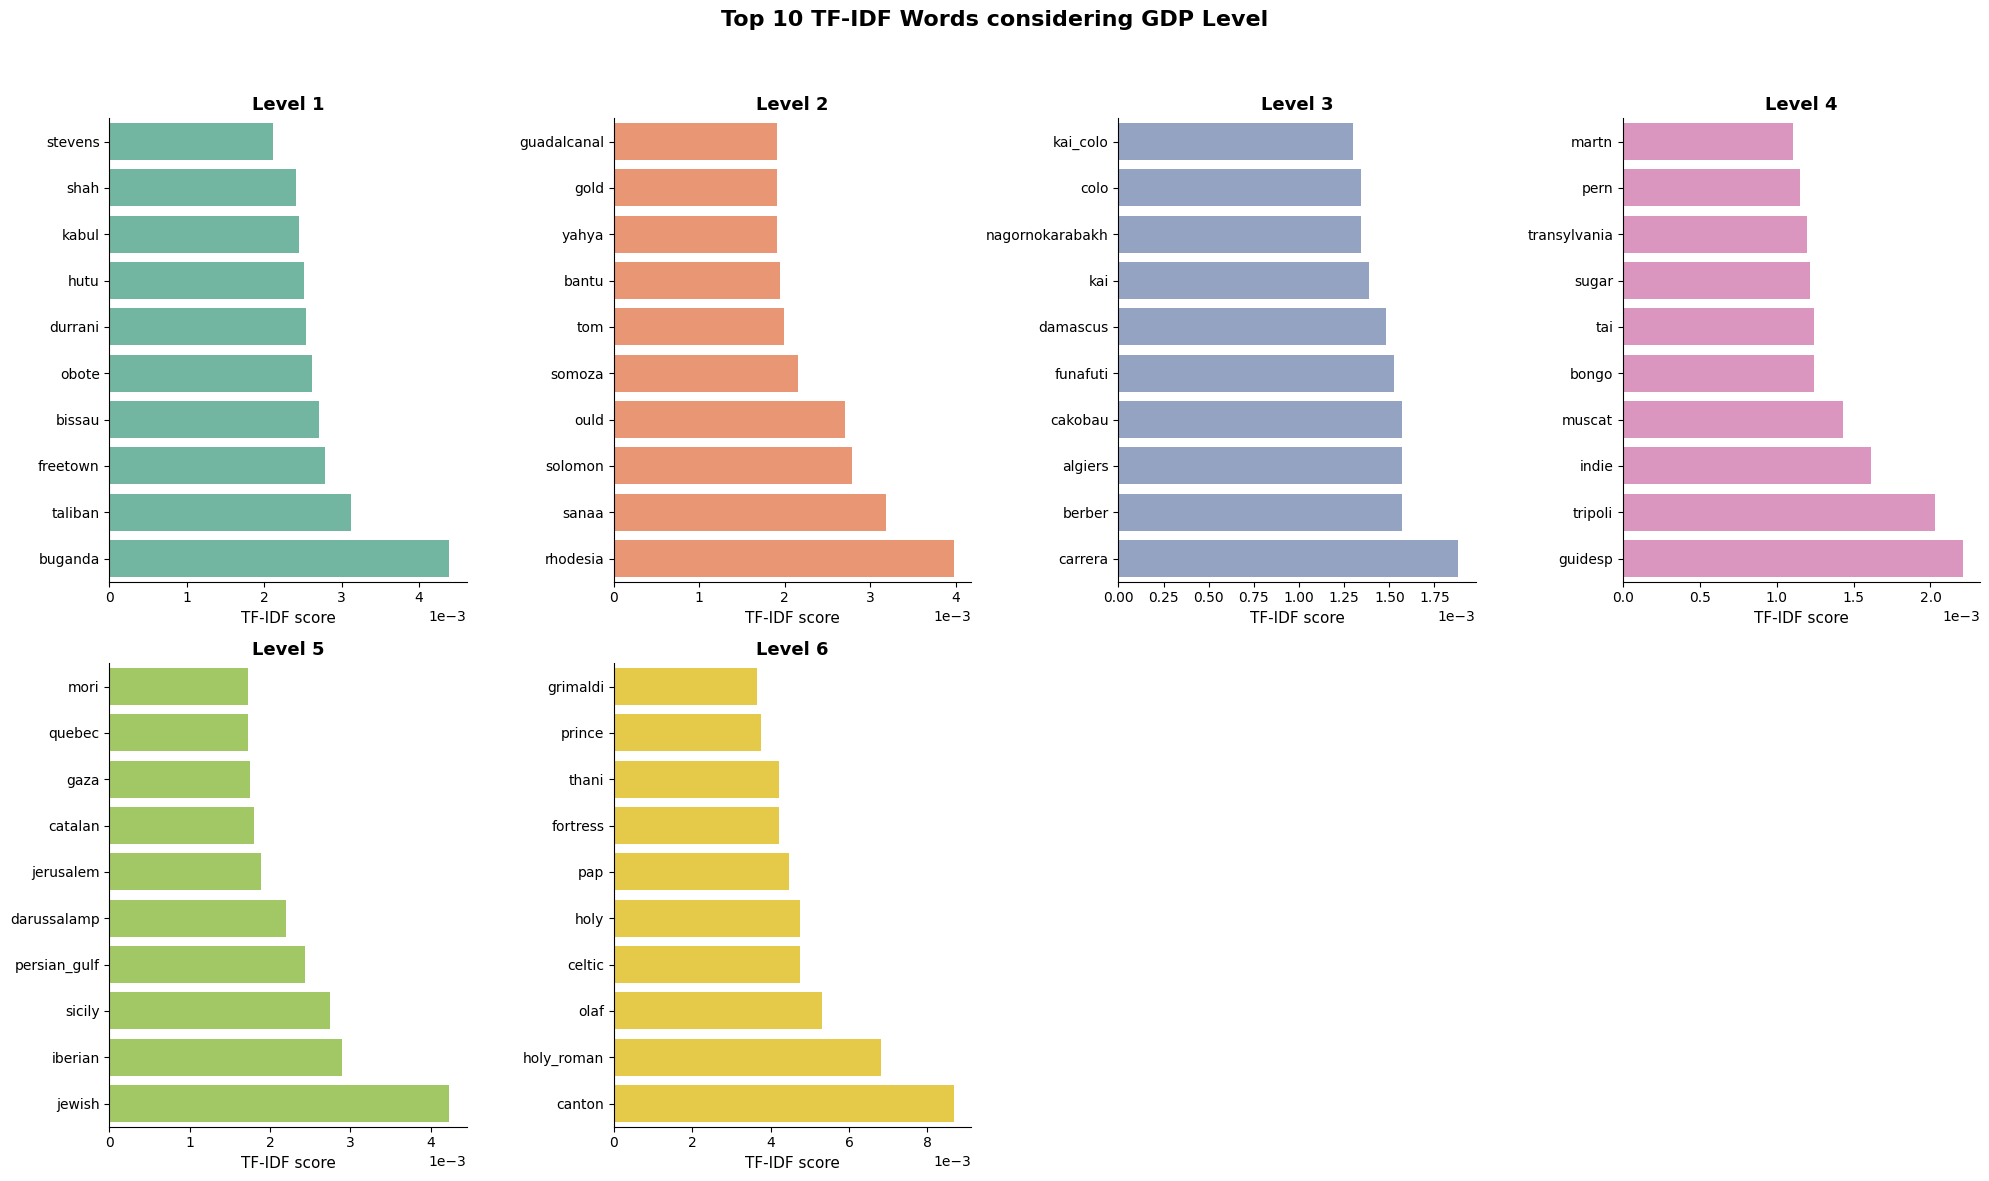

In [ ]:
plot_tfidf_bars(tfidf_gdp, label_type="GDP Level", save_path="plots/tfidf_gdp.png")

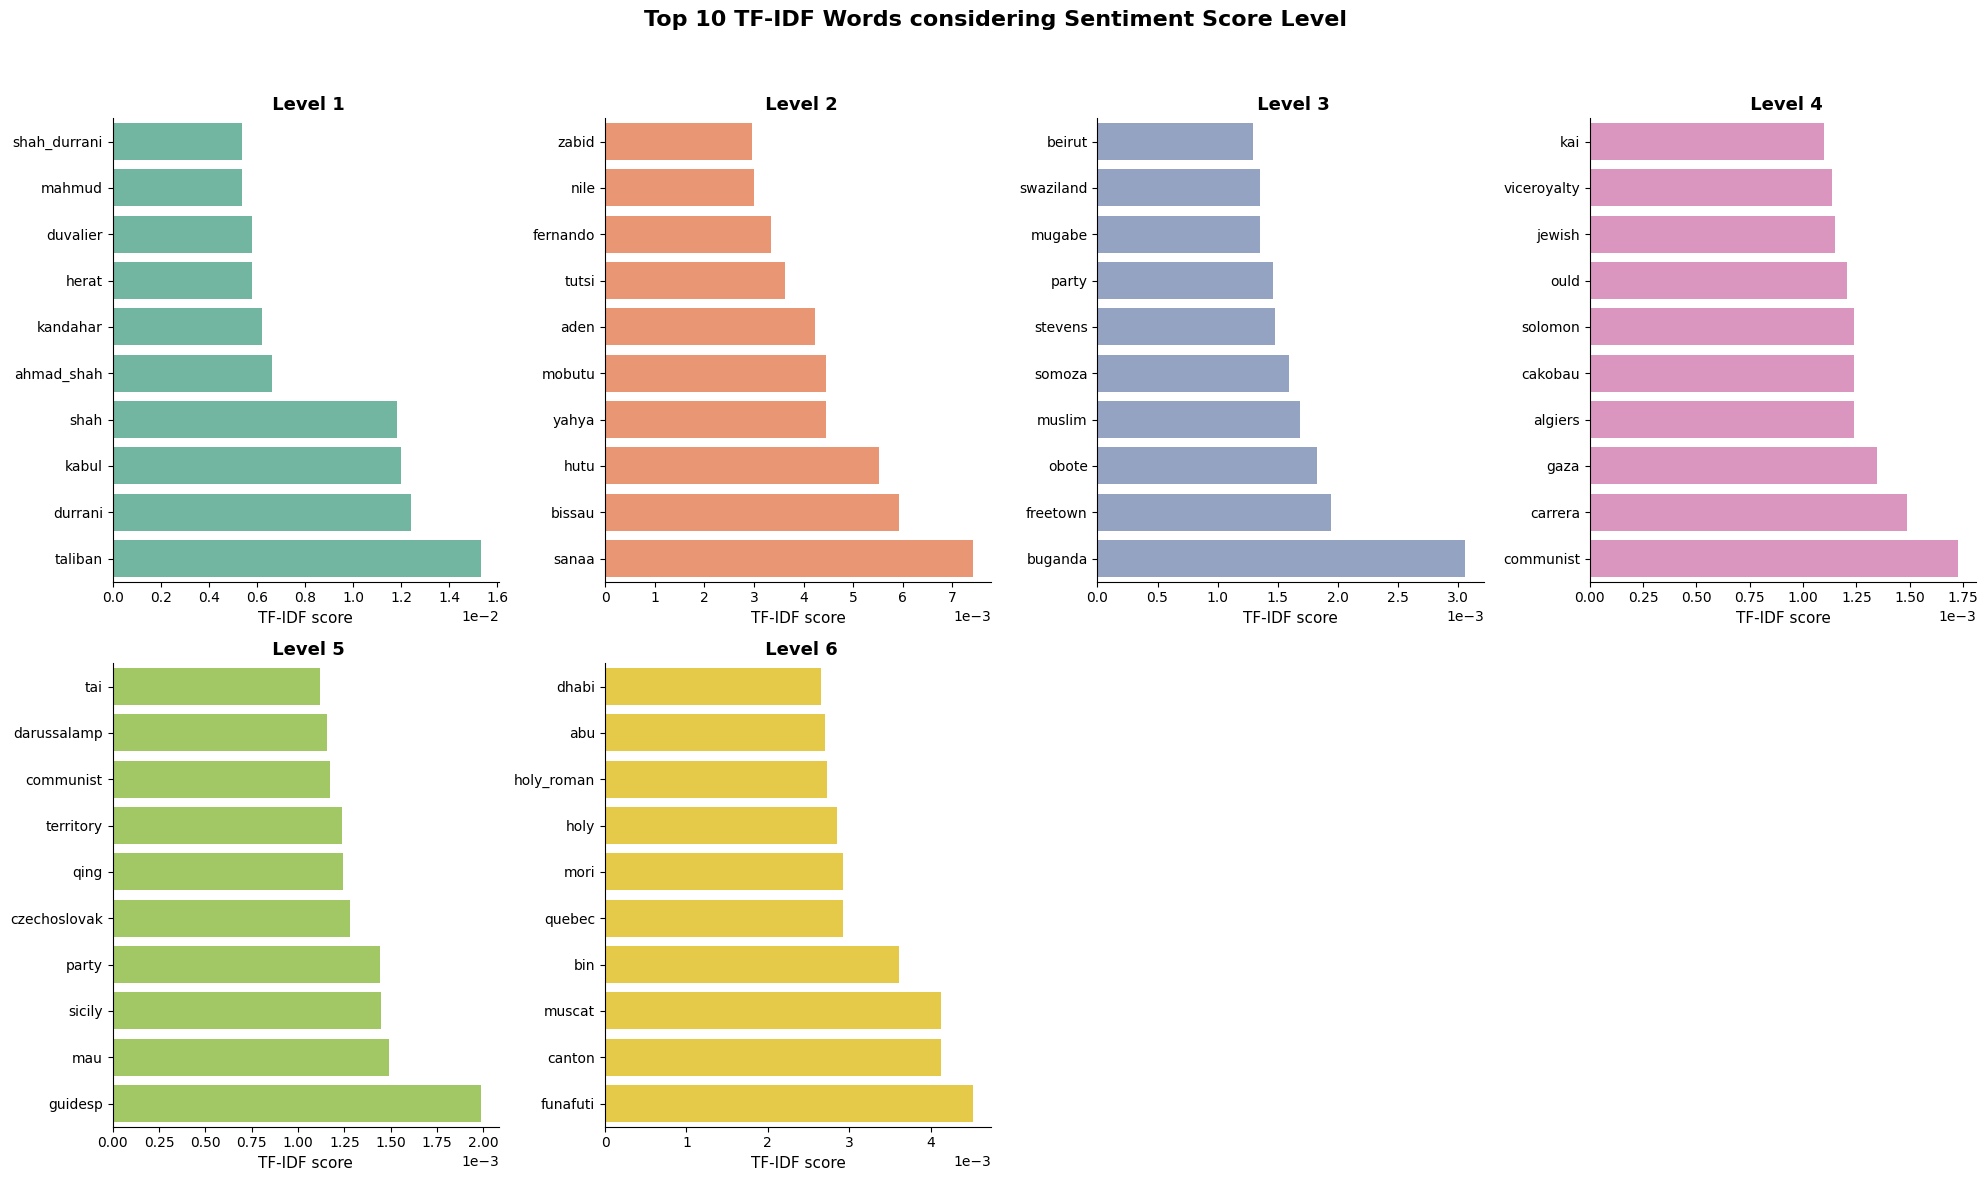

In [ ]:
plot_tfidf_bars(tfidf_sentiment, label_type="Sentiment Score Level", save_path="plots/tfidf_sentiment.png")

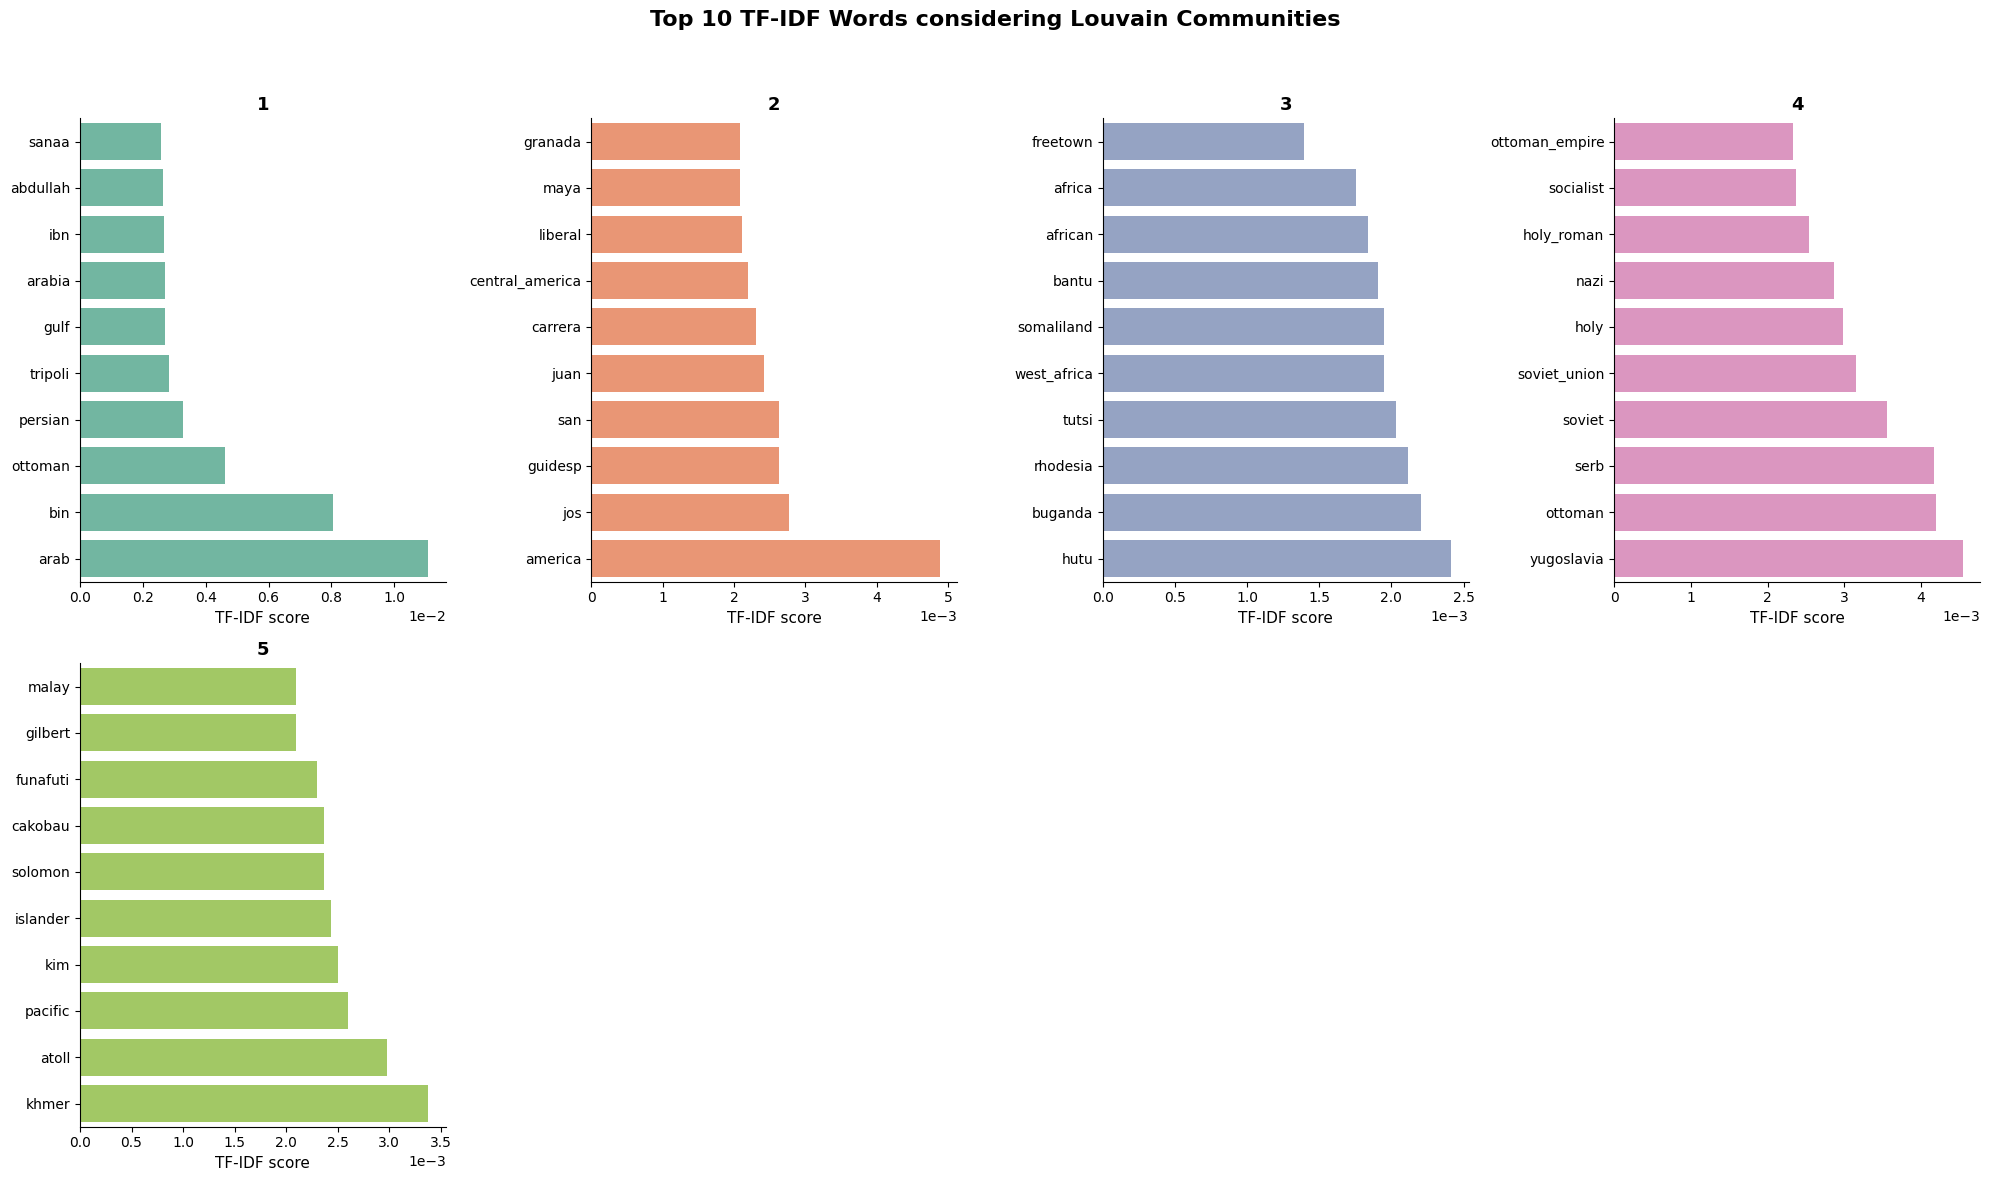

In [ ]:
plot_tfidf_bars(tfidf_louvain, label_type="Louvain Communities", save_path="plots/tfidf_louvain.png")


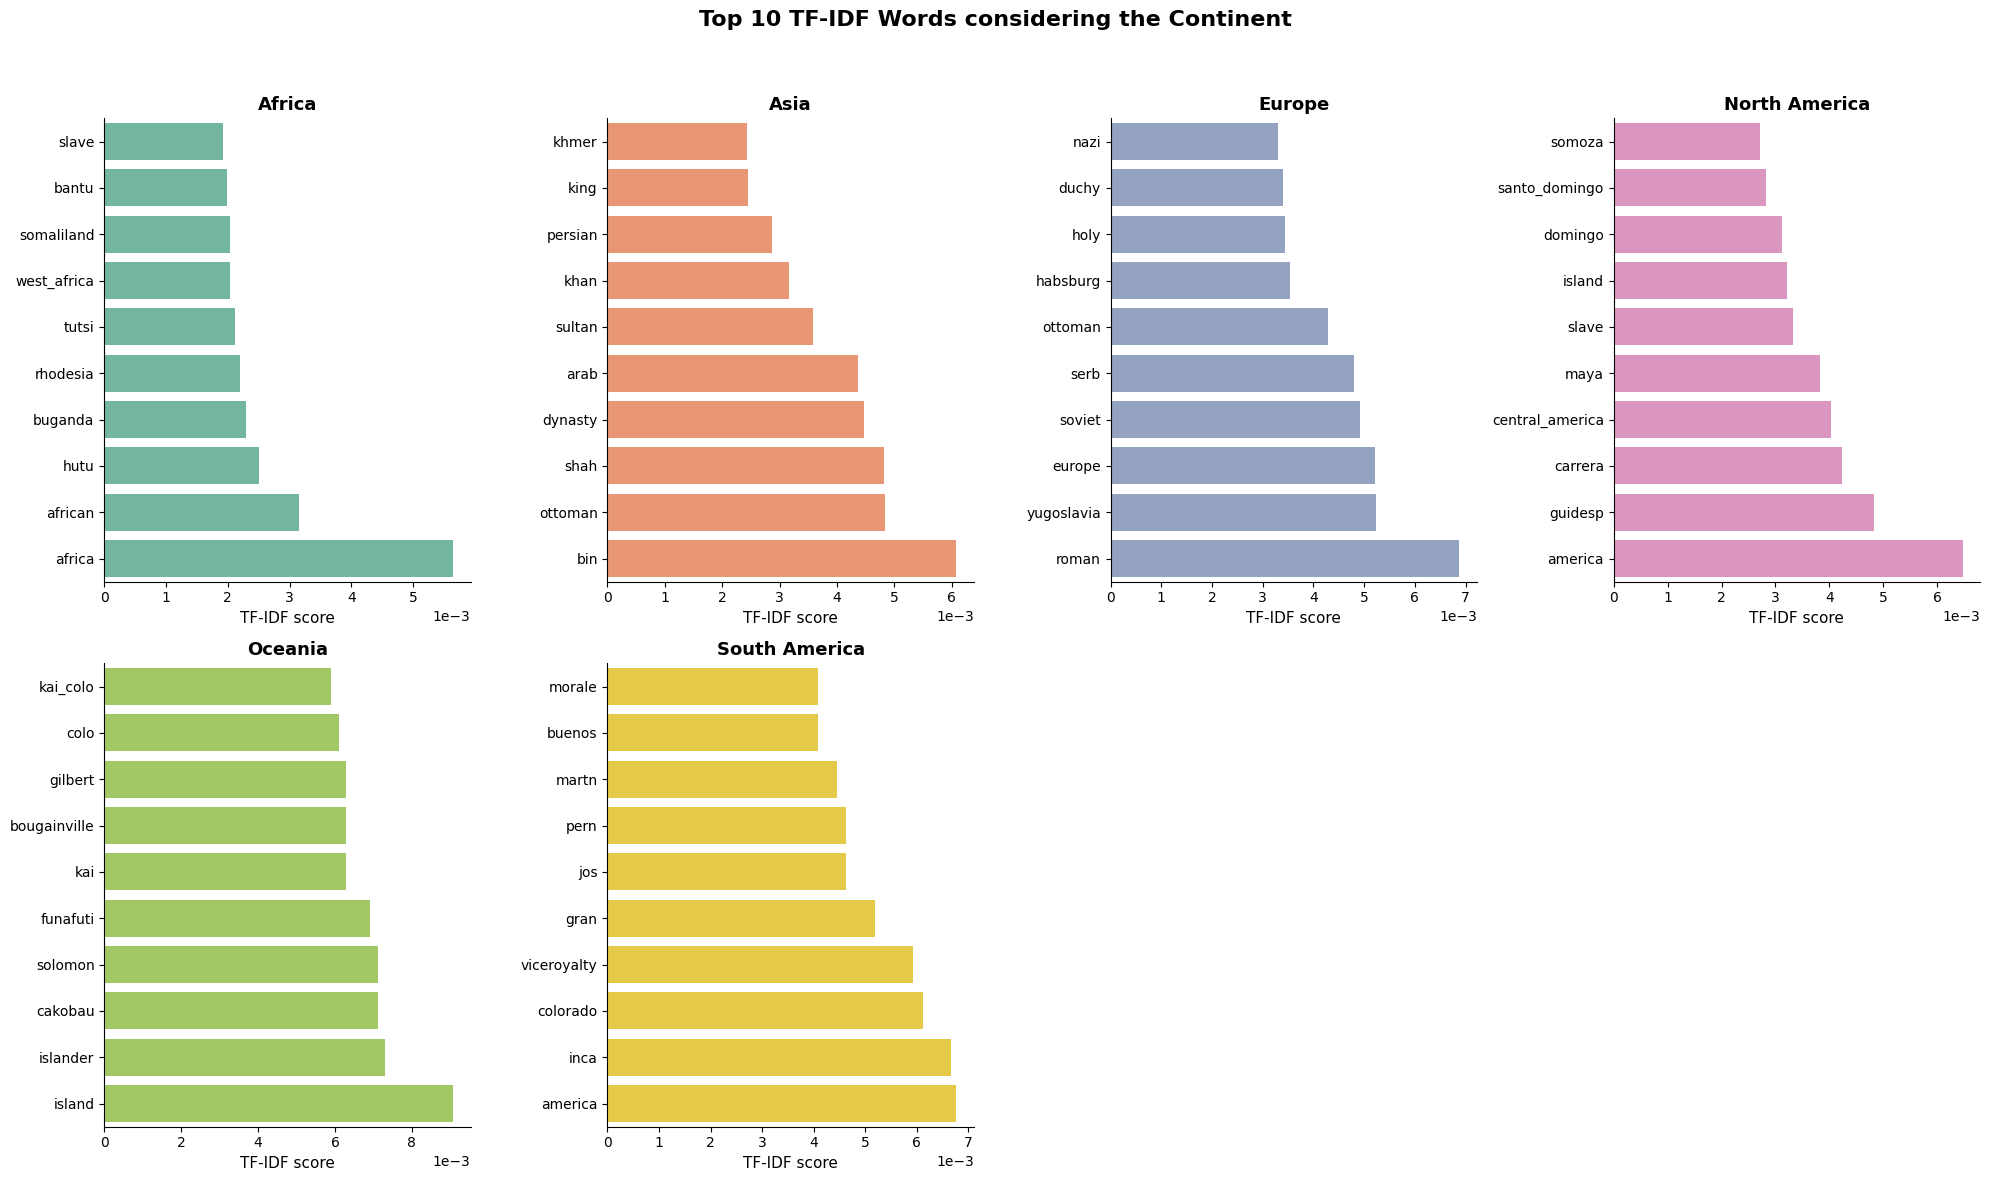

In [ ]:
plot_tfidf_bars(tfidf_continent, label_type="the Continent", save_path="plots/tfidf_continent.png")


Now, we will use another plotting function to compare the tf-idf from specific partitions inside them.

In [ ]:
#Prepare the tfidf of the different communities to be ploted together 
all_group_tfidf = {}
all_group_tfidf.update(tfidf_gdp)
all_group_tfidf.update(tfidf_sentiment)
all_group_tfidf.update(tfidf_continent)
all_group_tfidf.update(tfidf_louvain)

In [ ]:
def plot_selected_tfidf_groups(group_tfidf, groups_to_plot, top_n=10, title=None, save_path=None):
    """
    Plot TF-IDF bar charts for a selected subset of groups/communities/genres.

    Parameters
    group_tfidf : dict
        { group_name : {word: tfidf_score, ...}, ... }
    groups_to_plot : list of str
        Names of groups to include in the comparison plot.
        Must match keys in group_tfidf.
    top_n : int, optional
        Number of top TF-IDF words to show for each group.
    title : str, optional
        Title for the full figure.
    save_path : str or Path, optional
        If provided, saves the figure. Otherwise displays it.

    Returns
    None
    """

    # Format group names for nicer plot titles
    def format_group_name(name):
        return name.replace("_", " ").title()

    valid_groups = [g for g in groups_to_plot if g in group_tfidf]

    # Build a DataFrame of the selected groups
    rows = []
    for group in valid_groups:
        scores = group_tfidf[group]
        top_items = sorted(scores.items(), key=lambda x: x[1], reverse=True)[:top_n]

        for word, score in top_items:
            rows.append((format_group_name(group), word, score))

    df = pd.DataFrame(rows, columns=["Group", "Word", "TF-IDF"])

    # Grid configuration 
    n_groups = len(df["Group"].unique())
    n_cols = min(4, n_groups)
    n_rows = math.ceil(n_groups / n_cols)

    fig, axes = plt.subplots(
        n_rows, n_cols, 
        figsize=(5 * n_cols, 6 * n_rows), 
        sharey=False
    )

    axes = axes.flatten() if n_groups > 1 else [axes]

    # Plot each group
    palette = sns.color_palette("Set2", n_groups)

    for ax, (group, subdf), color in zip(axes, df.groupby("Group"), palette):
        sns.barplot(
            data=subdf,
            y="Word",
            x="TF-IDF",
            ax=ax,
            color=color
        )
        ax.set_title(group, fontsize=13, weight="bold")
        ax.set_xlabel("TF-IDF score", fontsize=11)
        ax.set_ylabel("")
        ax.invert_yaxis()
        sns.despine(ax=ax)
        ax.ticklabel_format(style="sci", axis="x", scilimits=(0, 0))
        ax.xaxis.get_offset_text().set_fontsize(10)

    # Hide unused axes 
    for j in range(len(df["Group"].unique()), len(axes)):
        axes[j].set_visible(False)

    # Global title 
    if title:
        fig.suptitle(title, fontsize=16, weight="bold")
    else:
        fig.suptitle("TF-IDF Comparison", fontsize=16, weight="bold")

    plt.tight_layout(rect=[0, 0, 1, 0.95])

    # Save or show 
    if save_path:
        Path(save_path).parent.mkdir(parents=True, exist_ok=True)
        plt.savefig(save_path, dpi=300, bbox_inches="tight")
    else:
        plt.show()


In [ ]:
interest_groups = [""]

### Word-Clouds

In [ ]:
def create_wordclouds(group_tfidf, out_folder, max_words=100):
    """
    Create and save word clouds for each community/group based on TF-IDF scores.

    Parameters
    group_tfidf : dict
        Dict from compute_tfidf(): {group_name: {word: tfidf_value}}
    out_folder : str or Path
        Folder where the PNG files will be saved
    max_words : int
        Maximum number of words in each word cloud

    Returns
    None
    """
    out_folder = Path(out_folder)
    out_folder.mkdir(exist_ok=True)

    for group_name, tfidf_scores in group_tfidf.items():
        if not tfidf_scores:
            continue

        # Normalize values (to help visual scaling)
        max_val = max(tfidf_scores.values())
        freqs = {word: score / max_val for word, score in tfidf_scores.items()}

        # Create world-cloud 
        wc = WordCloud(
            width=1200,
            height=800,
            background_color="white",
            max_words=max_words,
            colormap="viridis",
            random_state=42
        ).generate_from_frequencies(freqs)

        # Save figure
        plt.figure(figsize=(10, 6))
        plt.imshow(wc, interpolation="bilinear")
        plt.axis("off")
        out_path = out_folder / f"{group_name}_wordcloud.png"
        plt.tight_layout()
        plt.savefig(out_path, dpi=300)
        plt.close()

In [ ]:
create_wordclouds(tfidf_gdp, "wordclouds_gdp_level")

In [ ]:
create_wordclouds(tfidf_sentiment, "wordclouds_sentiment_score_level")

In [ ]:
create_wordclouds(tfidf_louvain, "wordclouds_louvain")

In [ ]:
create_wordclouds(tfidf_continent, "wordclouds_continent")

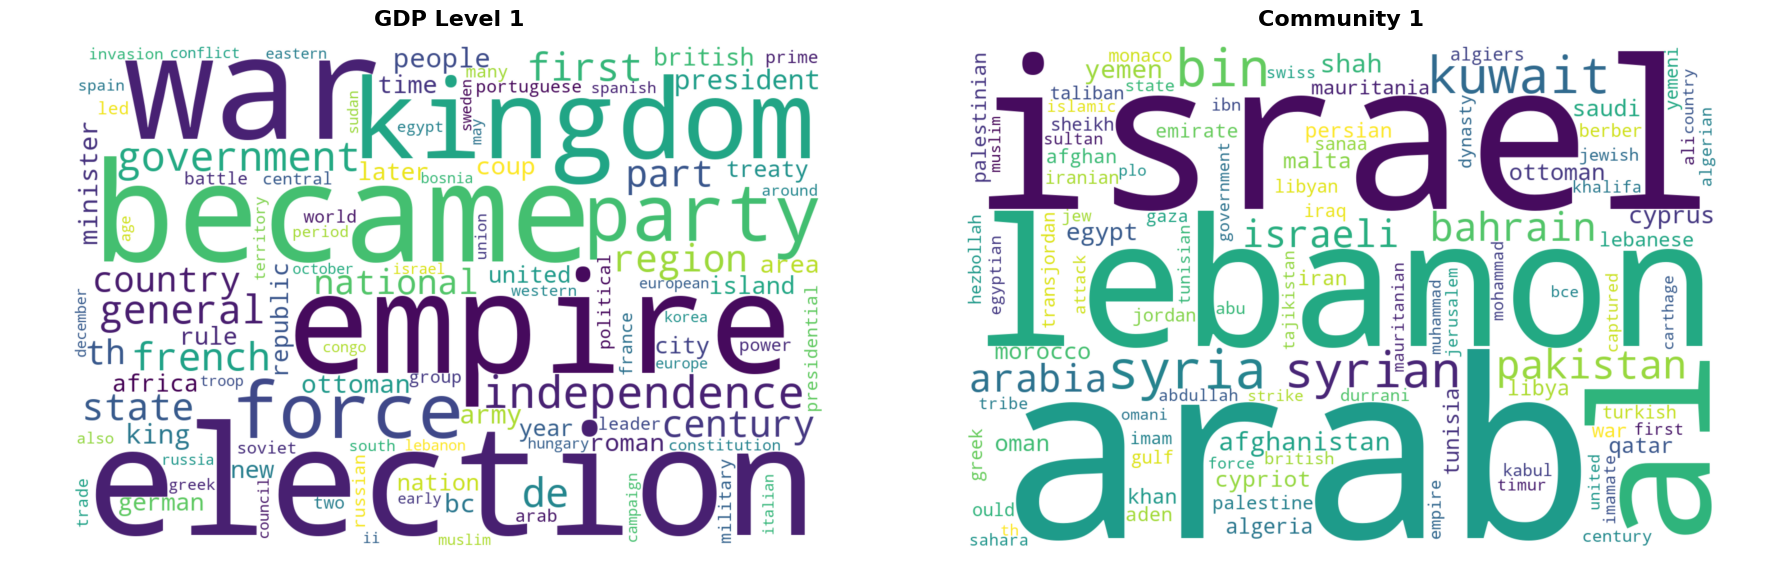

In [ ]:
# image paths 
img1 = Path("wordclouds_gdp_level\LEVEL_1_wordcloud.png")     
img2 = Path("wordclouds_louvain/1_wordcloud.png")      

titles = [ "GDP Level 1", "Community 1"]

# Plot them side by side
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

for ax, img_path, title in zip(axes, [img1, img2], titles):
    img = mpimg.imread(img_path)
    ax.imshow(img)
    ax.axis("off")
    ax.set_title(title, fontsize=16, weight="bold")

plt.tight_layout()
plt.show()